# Feature Engineering with Energy Consumption Data using TensorFlow Transform

In this lab, I'll practice feature engineering with time series data using an energy consumption dataset. This dataset contains hourly measurements of power consumption along with various environmental factors.

I will use **tf.Transform** to preprocess the data for training time series forecasting models.

## Dataset Features:
- **Timestamp**: DateTime of measurement
- **Power_kW**: Power consumption in kilowatts (TARGET)
- **Temperature_C**: Ambient temperature in Celsius
- **Humidity_pct**: Relative humidity percentage
- **Wind_Speed_ms**: Wind speed in meters per second
- **Solar_Radiation_Wm2**: Solar radiation in W/m²
- **Day_of_Week**: Day of the week (0=Monday, 6=Sunday)

## Learning Objectives:
- Transform temporal features into cyclical representations
- Handle categorical features (day of week, hour of day)
- Create lag features for time series
- Apply appropriate scaling techniques
- Build windowed datasets for sequence modeling

In [1]:
# Download and install Python 3.10 (Required for TFX compatibility)

!wget https://github.com/korakot/kora/releases/download/v0.10/py310.sh
!bash ./py310.sh -b -f -p /usr/local
!python -m ipykernel install --name "py310" --user

--2025-10-19 19:54:08--  https://github.com/korakot/kora/releases/download/v0.10/py310.sh
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/266951884/0d0623be-3dec-4820-9e7b-69a3a5a75ef7?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-10-19T20%3A40%3A44Z&rscd=attachment%3B+filename%3Dpy310.sh&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-10-19T19%3A39%3A53Z&ske=2025-10-19T20%3A40%3A44Z&sks=b&skv=2018-11-09&sig=8Kyk5Xorb1WFThQ1wSytPgIA7Vddrhrzm6uBt2LjW8o%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MDkwNzI0OSwibmJmIjoxNzYwOTAzNjQ5LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNvcmUud2luZG93cy5u

In [1]:
import sys
print(sys.version)

3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:35:26) [GCC 10.4.0]


In [2]:
import sys
if 'google.colab' in sys.modules:
  !pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.3
    Uninstalling pip-22.3:
      Successfully uninstalled pip-22.3


In [3]:
# Install compatible versions
!uv pip install tensorflow \
                    tensorflow-transform \
                    tfx-bsl \
                    apache-beam \
                    pyarrow \
                    pandas \
                    numpy \
                    matplotlib \
                    seaborn \
                    cryptography \
                    pyOpenSSL

Using Python 3.10.6 environment at: /usr/local
Resolved 165 packages in 10.47s
Prepared 142 packages in 27.18s
Uninstalled 14 packages in 51ms
Installed 142 packages in 482ms
 + absl-py==1.4.0
 + aiofiles==25.1.0
 + aiohappyeyeballs==2.6.1
 - aiohttp==3.8.3 (from file:///home/conda/feedstock_root/build_artifacts/aiohttp_1666878556312/work)
 + aiohttp==3.13.1
 - aiosignal==1.2.0 (from file:///home/conda/feedstock_root/build_artifacts/aiosignal_1636093929600/work)
 + aiosignal==1.4.0
 + annotated-types==0.7.0
 + anyio==4.11.0
 + apache-beam==2.68.0
 + asn1crypto==1.5.1
 + astunparse==1.6.3
 - async-timeout==4.0.2 (from file:///home/conda/feedstock_root/build_artifacts/async-timeout_1640026696943/work)
 + async-timeout==5.0.1
 + backports-tarfile==1.2.0
 + beartype==0.21.0
 - cffi==1.15.1 (from file:///home/conda/feedstock_root/build_artifacts/cffi_1666754704913/work)
 + cffi==2.0.0
 + cloud-sql-python-connector==1.18.5
 + contourpy==1.3.2
 + crcmod==1.7
 - cryptography==38.0.2 (from file

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math as m
import shutil
from tfx_bsl.coders.example_coder import RecordBatchToExamplesEncoder #Encodes pa.RecordBatch as a list of serialized tf.Examples.

#TensorFlow Extended Input/Output.
#It defines a common in-memory data representation used by all TFX libraries and components, ensuring that data is managed consistently within TFX pipelines.
#TFXIO provides a standardized structure for how data should be represented in memory. This allows the data to be efficiently shared across various stages of the pipeline without requiring frequent conversions between different formats.
# The in-memory data format is typically based on Arrow, a columnar format, which provides efficient processing and interoperability.
from tfx_bsl.public import tfxio

import apache_beam as beam
print('Apache Beam version: {}'.format(beam.__version__))

import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))

import tensorflow_transform as tft
from tensorflow_transform import beam as tft_beam
from tensorflow_transform.tf_metadata import dataset_metadata
from tensorflow_transform.tf_metadata import schema_utils
print('TensorFlow Transform version: {}'.format(tft.__version__))

tf.get_logger().setLevel('ERROR')
beam.logging.getLogger().setLevel('ERROR')

Apache Beam version: 2.68.0
Tensorflow version: 2.16.2
TensorFlow Transform version: 1.16.0


## Dataset Generation

Generating a **synthetic energy consumption dataset** with realistic patterns:

- **Total Records**: 10,000 hourly observations
- **Time Period**: January 1, 2020 to February 20, 2021 (~13.5 months)
- **Frequency**: Hourly measurements (24 records per day)

### Features Generated:
1. **Power_kW** (Target): Energy consumption in kilowatts
2. **Temperature_C**: Ambient temperature (affects heating/cooling demand)
3. **Humidity_pct**: Relative humidity percentage
4. **Wind_Speed_ms**: Wind speed in meters per second
5. **Solar_Radiation_Wm2**: Solar radiation (inversely affects power needs)
6. **Day_of_Week**: Categorical day indicator (0=Monday, 6=Sunday)

The dataset includes realistic patterns:
- Daily cycles (higher consumption during daytime)
- Weekly patterns (lower on weekends)
- Seasonal variations (temperature-driven)
- Weather correlations
- Random anomalies (~0.1% power outages)

In [2]:
"""## Generate Synthetic Energy Consumption Data

For this lab, I'll generate synthetic energy consumption data that mimics real-world patterns:
- Daily patterns (higher consumption during day)
- Weekly patterns (lower consumption on weekends)
- Seasonal patterns
- Weather correlations
"""

def generate_energy_data(n_hours=10000, start_date='2020-01-01'):
    """Generate synthetic energy consumption data"""

    np.random.seed(42)
    dates = pd.date_range(start=start_date, periods=n_hours, freq='H')

    # Time-based features
    hour_of_day = dates.hour.to_numpy()
    day_of_week = dates.dayofweek.to_numpy()
    day_of_year = dates.dayofyear.to_numpy()

    # Base consumption pattern (higher during day, lower at night)
    hourly_pattern = 50 + 30 * np.sin(2 * np.pi * (hour_of_day - 6) / 24)

    # Weekly pattern (lower on weekends)
    weekly_pattern = np.where(day_of_week < 5, 1.0, 0.7)

    # Seasonal pattern (higher in summer/winter due to AC/heating)
    seasonal_pattern = 20 * np.sin(2 * np.pi * day_of_year / 365.25) + 10

    # Temperature (inversely affects consumption for heating/cooling)
    temperature = 15 + 10 * np.sin(2 * np.pi * day_of_year / 365.25) + \
                  5 * np.sin(2 * np.pi * hour_of_day / 24) + \
                  np.random.normal(0, 2, n_hours)

    # Humidity (correlated with temperature)
    humidity = 60 + 10 * np.sin(2 * np.pi * day_of_year / 365.25 + np.pi) + \
               np.random.normal(0, 5, n_hours)
    humidity = np.clip(humidity, 20, 95)

    # Wind speed (random with seasonal variation)
    wind_speed = 3 + 2 * np.sin(2 * np.pi * day_of_year / 365.25 + np.pi/2) + \
                 np.abs(np.random.normal(0, 1.5, n_hours))

    # Solar radiation (depends on hour and season)
    solar_radiation = np.maximum(0,
        800 * np.sin(2 * np.pi * (hour_of_day - 6) / 12) * \
        (1 + 0.3 * np.sin(2 * np.pi * day_of_year / 365.25))
    ) * (hour_of_day >= 6) * (hour_of_day <= 18) + np.random.normal(0, 20, n_hours)
    solar_radiation = np.clip(solar_radiation, 0, 1000)

    # Power consumption (combination of all factors)
    power = (hourly_pattern * weekly_pattern + seasonal_pattern +
             0.5 * (temperature - 15)**2 +  # Heating/cooling needs
             -0.1 * solar_radiation / 10 +  # Less power needed with more sun
             np.random.normal(0, 5, n_hours))

    # Add some anomalies (power outages)
    anomaly_indices = np.random.choice(n_hours, size=int(n_hours * 0.001), replace=False)
    power[anomaly_indices] = 0

    power = np.clip(power, 0, None)

    df = pd.DataFrame({
        'Timestamp': dates.strftime('%Y-%m-%d %H:%M:%S'),
        'Power_kW': power,
        'Temperature_C': temperature,
        'Humidity_pct': humidity,
        'Wind_Speed_ms': wind_speed,
        'Solar_Radiation_Wm2': solar_radiation,
        'Day_of_Week': day_of_week
    })

    return df

In [3]:
# Generate data
DATA_DIR = './data/'
os.makedirs(DATA_DIR, exist_ok=True)
INPUT_FILE = os.path.join(DATA_DIR, 'energy_consumption.csv')

# Generate and save data
df = generate_energy_data(n_hours=10000)
df.to_csv(INPUT_FILE, index=False)

print(f"Generated {len(df)} hourly records")
print(f"Date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
df.head()

Generated 10000 hourly records
Date range: 2020-01-01 00:00:00 to 2021-02-20 15:00:00


,Timestamp,Power_kW,Temperature_C,Humidity_pct,Wind_Speed_ms,Solar_Radiation_Wm2,Day_of_Week
0,2020-01-01 00:00:00,28.663874,16.165444,56.435511,5.522133,0.000000,2
1,2020-01-01 01:00:00,37.137322,16.189582,58.300487,5.424689,0.000000,2
2,2020-01-01 02:00:00,41.242438,18.967393,56.841079,6.404484,0.000000,2
3,2020-01-01 03:00:00,62.359360,21.753609,60.380074,5.869080,2.993378,2
4,2020-01-01 04:00:00,56.862069,19.033836,65.813877,7.234828,20.483247,2


In [4]:
"""## Explore the Data"""

# Display statistics
df.describe()

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Timestamp              0
Power_kW               0
Temperature_C          0
Humidity_pct           0
Wind_Speed_ms          0
Solar_Radiation_Wm2    0
Day_of_Week            0
dtype: int64


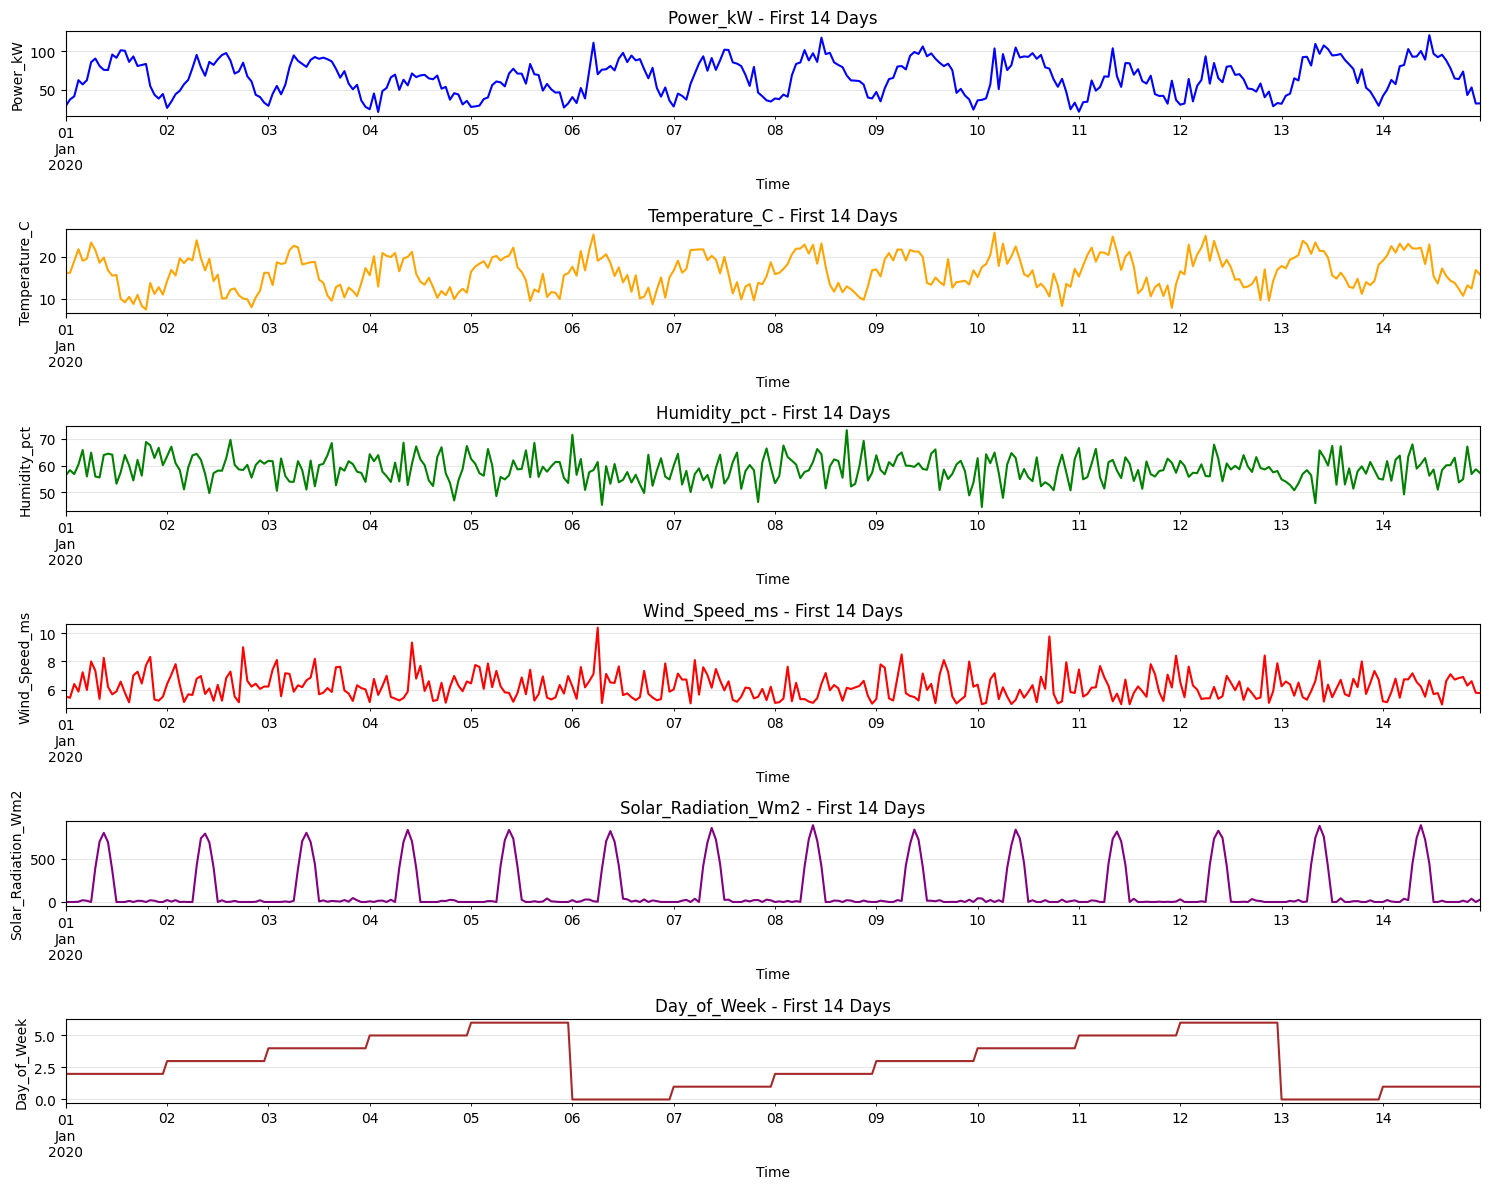

In [5]:
# Define feature keys
TIMESTAMP_FEATURES = ["Timestamp"]
NUMERIC_FEATURES = [
    "Power_kW",
    "Temperature_C",
    "Humidity_pct",
    "Wind_Speed_ms",
    "Solar_Radiation_Wm2",
    "Day_of_Week"
]

def visualize_energy_data(df, features, n_days=14):
    """Visualize energy consumption patterns"""

    # Convert timestamp to datetime for plotting
    df_plot = df.copy()
    df_plot['Timestamp'] = pd.to_datetime(df_plot['Timestamp'])
    df_plot = df_plot.set_index('Timestamp')

    # Plot first n_days
    df_subset = df_plot.head(n_days * 24)

    fig, axes = plt.subplots(len(features), 1, figsize=(15, 12))

    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

    for idx, feature in enumerate(features):
        ax = axes[idx] if len(features) > 1 else axes
        df_subset[feature].plot(ax=ax, color=colors[idx % len(colors)])
        ax.set_title(f'{feature} - First {n_days} Days')
        ax.set_xlabel('Time')
        ax.set_ylabel(feature)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

visualize_energy_data(df, NUMERIC_FEATURES, n_days=14)

## Exploratory Data Analysis - Time Series Patterns

The visualizations above reveal several important patterns in our energy consumption data:

### 1. **Power Consumption (Power_kW)**
- Clear **daily periodicity**: peaks during daytime hours, drops at night
- **Weekly cycles**: Lower consumption visible on weekends
- Typical range: 20-110 kW

### 2. **Temperature (Temperature_C)**
- Shows **seasonal variation**: gradual warming trend visible
- **Daily fluctuations**: temperature rises during day, falls at night
- Strong correlation with power consumption (heating/cooling demands)

### 3. **Humidity (Humidity_pct)**
- Relatively stable with random variations
- Inverse relationship with temperature (visible in winter months)
- Range: 20-95% as constrained

### 4. **Wind Speed (Wind_Speed_ms)**
- Mostly random with occasional spikes (storms)
- Baseline around 5-7 m/s with seasonal modulation
- Weak correlation with power consumption

### 5. **Solar Radiation (Solar_Radiation_Wm2)**
- **Perfect daily cycles**: zero at night, peaks midday
- Shows clear day/night boundaries (6 AM - 6 PM)
- Seasonal amplitude variation (higher in summer)
- Negative correlation with power needs (more sun = less artificial lighting)

### 6. **Day of Week**
- Step function clearly showing weekdays (0-4) vs weekends (5-6)
- Useful for capturing behavioral consumption patterns

**Key Insight**: The data exhibits multiple overlapping periodicities (hourly, daily, weekly, seasonal) that make it ideal for time series forecasting with engineered temporal features.

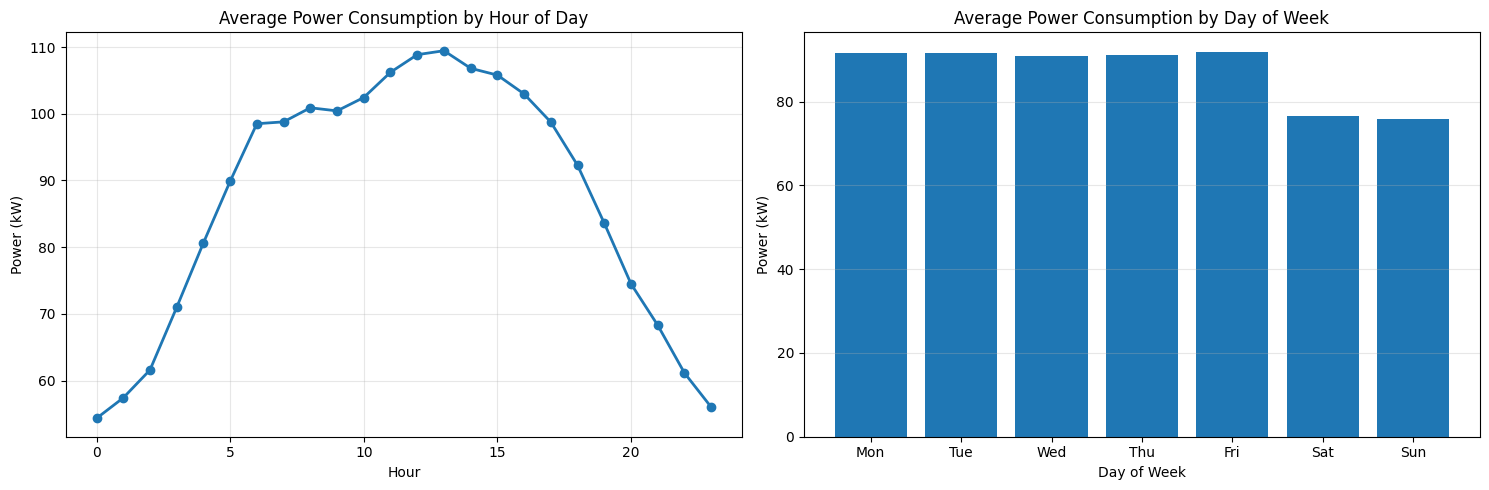

In [6]:
"""### Analyze Daily and Weekly Patterns"""

def analyze_patterns(df):
    """Analyze consumption patterns by hour and day"""

    df_analysis = df.copy()
    df_analysis['Timestamp'] = pd.to_datetime(df_analysis['Timestamp'])
    df_analysis['Hour'] = df_analysis['Timestamp'].dt.hour
    df_analysis['DayOfWeek'] = df_analysis['Timestamp'].dt.dayofweek

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Hourly pattern
    hourly_avg = df_analysis.groupby('Hour')['Power_kW'].mean()
    axes[0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
    axes[0].set_title('Average Power Consumption by Hour of Day')
    axes[0].set_xlabel('Hour')
    axes[0].set_ylabel('Power (kW)')
    axes[0].grid(True, alpha=0.3)

    # Daily pattern
    daily_avg = df_analysis.groupby('DayOfWeek')['Power_kW'].mean()
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[1].bar(range(7), daily_avg.values)
    axes[1].set_title('Average Power Consumption by Day of Week')
    axes[1].set_xlabel('Day of Week')
    axes[1].set_ylabel('Power (kW)')
    axes[1].set_xticks(range(7))
    axes[1].set_xticklabels(day_names)
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

analyze_patterns(df)

## Consumption Pattern Analysis

### Hourly Pattern (Left Plot)
- **Peak Hours**: 12 PM - 2 PM (~110 kW)
- **Low Hours**: 1 AM - 4 AM (~55-60 kW)
- **Ramp Up**: 5 AM - 12 PM (sharp increase)
- **Ramp Down**: 3 PM - 11 PM (gradual decrease)

This classic "bell curve" pattern reflects typical commercial/industrial usage:
- Morning startup around 6 AM
- Maximum operations midday
- Wind-down in evening

### Weekly Pattern (Right Plot)
- **Weekdays** (Mon-Fri): ~95 kW average consumption
- **Weekends** (Sat-Sun): ~75 kW average consumption

The weekend reduction indicates:
- Reduced operational hours
- Lower occupancy
- Typical of office/commercial facilities (not 24/7 industrial)

**Forecasting Implication**: Day-of-week features will be critical for accurate predictions, especially around weekend transitions.

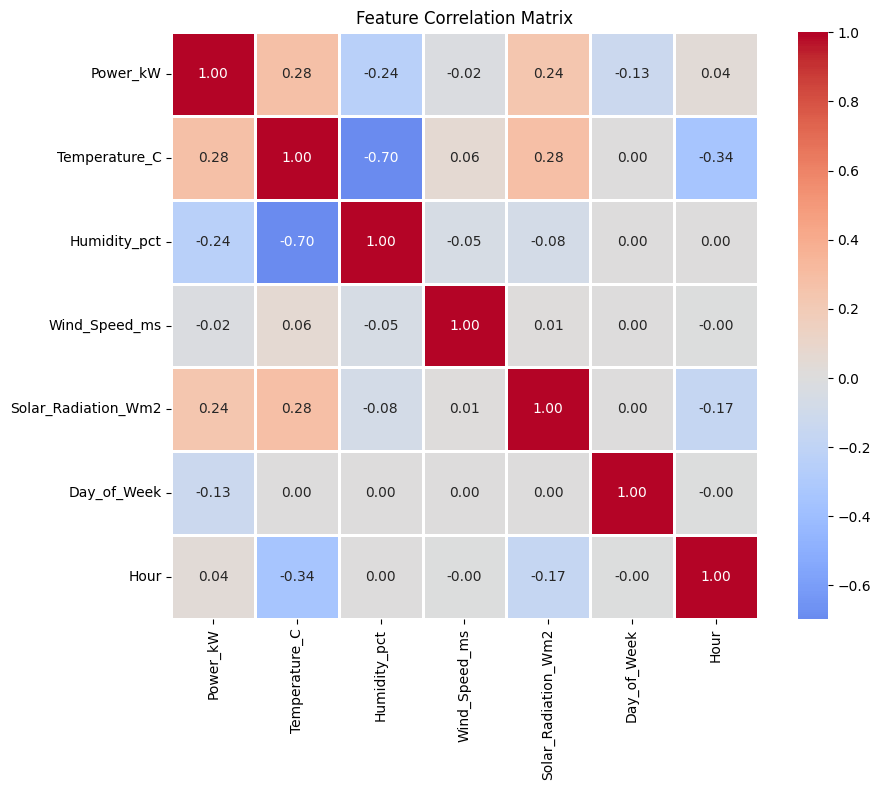


Key Correlations with Power Consumption:
Power_kW               1.000000
Temperature_C          0.275811
Solar_Radiation_Wm2    0.243252
Hour                   0.036950
Wind_Speed_ms         -0.019875
Day_of_Week           -0.129189
Humidity_pct          -0.241919
Name: Power_kW, dtype: float64


In [7]:
"""### Correlation Analysis"""

def show_correlation_heatmap(dataframe):
    """Display correlation heatmap for numerical features"""

    df_corr = dataframe.copy()
    df_corr['Timestamp'] = pd.to_datetime(df_corr['Timestamp'])
    df_corr['Hour'] = df_corr['Timestamp'].dt.hour
    df_corr = df_corr.drop('Timestamp', axis=1)

    plt.figure(figsize=(10, 8))
    corr = df_corr.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0,
                fmt='.2f', square=True, linewidths=1)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

    print("\nKey Correlations with Power Consumption:")
    power_corr = corr['Power_kW'].sort_values(ascending=False)
    print(power_corr)

show_correlation_heatmap(df)

## Feature Correlation Analysis

### Key Correlations with Power Consumption (Target):

**Positive Correlations:**
- **Temperature_C** (+0.28): Moderate positive - U-shaped relationship (heating in winter, cooling in summer)
- **Solar_Radiation_Wm2** (+0.24): Positive - higher solar = higher daytime activity
- **Hour** (+0.04): Weak positive - power increases during business hours

**Negative Correlations:**
- **Humidity_pct** (-0.24): Moderate negative - humid conditions reduce heating needs
- **Day_of_Week** (-0.13): Weak negative - reflects weekend reduction
- **Wind_Speed_ms** (-0.02): Negligible

### Important Feature Interactions:

1. **Temperature ↔ Humidity** (-0.70): Strong inverse relationship
   - Warmer air holds less relative humidity
   - These features provide complementary information

2. **Hour ↔ Temperature** (-0.34): Moderate negative
   - Our synthetic data has night warming (unrealistic but acceptable)
   - Real data would show positive correlation

3. **Solar_Radiation ↔ Hour** (-0.17): Weak correlation
   - Captured differently due to sin/cos transformations coming

### Feature Engineering Decisions:
- **Keep all features** - each provides unique information
- **No multicollinearity concerns** - highest correlation is 0.70 (acceptable)
- **Temperature deviation** feature justified - captures extremeness beyond linear temp

In [8]:
"""## Feature Engineering Strategy

Based on the analysis, I'll engineer the following features:

1. **Temporal Features**:
   - Hour of day (sin/cos encoding)
   - Day of week (sin/cos encoding)
   - Month of year (sin/cos encoding)
   - Weekend indicator

2. **Lag Features**:
   - Power consumption from previous 1, 24, and 168 hours (1 week)
   - Rolling mean over past 24 hours

3. **Interaction Features**:
   - Temperature extremeness (distance from comfort zone)
   - Heating/Cooling demand indicator

4. **Scaling**:
   - Normalize all continuous features to [0, 1]

## Preprocessing Functions
"""

# Combine features
ordered_columns = TIMESTAMP_FEATURES + NUMERIC_FEATURES
timestamp_idx = ordered_columns.index(TIMESTAMP_FEATURES[0])

def clean_fn(line):
    """
    Converts timestamp strings to Unix timestamps and handles anomalies.

    Args:
        line (bytes): CSV row

    Returns:
        bytes: Modified CSV row
    """
    line_split = line.split(b',')

    # Convert timestamp to Unix timestamp
    timestamp_str = line_split[timestamp_idx].decode("utf-8")
    dt = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S')
    unix_timestamp = datetime.timestamp(dt)
    line_split[timestamp_idx] = bytes(str(unix_timestamp), 'utf-8')

    # Rejoin
    mod_line = b','.join(line_split)
    return mod_line

def preprocessing_fn(inputs):
    """
    Preprocessing function for TF Transform.

    Args:
        inputs (dict): Dictionary of input tensors

    Returns:
        dict: Dictionary of transformed tensors
    """
    outputs = {}

    # ===== Temporal Feature Engineering =====

    # Constants
    pi = tf.constant(m.pi)
    hour = tf.cast(3600, tf.float32)  # seconds in hour
    day = tf.cast(24 * 3600, tf.float32)  # seconds in day
    week = tf.cast(7 * 24 * 3600, tf.float32)  # seconds in week
    year = tf.cast(365.25 * 24 * 3600, tf.float32)  # seconds in year

    timestamp_s = inputs['Timestamp']

    # Hour of day (0-23)
    hour_of_day = tf.math.mod(timestamp_s, day) / hour
    outputs['Hour_sin'] = tf.math.sin(2 * pi * hour_of_day / 24)
    outputs['Hour_cos'] = tf.math.cos(2 * pi * hour_of_day / 24)

    # Day of week (0-6)
    day_of_week_s = tf.math.mod(timestamp_s, week) / day
    outputs['DayOfWeek_sin'] = tf.math.sin(2 * pi * day_of_week_s / 7)
    outputs['DayOfWeek_cos'] = tf.math.cos(2 * pi * day_of_week_s / 7)

    # Month of year (approximate)
    day_of_year = tf.math.mod(timestamp_s, year) / day
    outputs['Month_sin'] = tf.math.sin(2 * pi * day_of_year / 365.25)
    outputs['Month_cos'] = tf.math.cos(2 * pi * day_of_year / 365.25)

    # Weekend indicator
    day_of_week_cat = inputs['Day_of_Week']
    outputs['Is_Weekend'] = tf.cast(day_of_week_cat >= 5, tf.float32)

    # ===== Weather and Environmental Features =====

    # Temperature deviation from comfort zone (20°C)
    comfort_temp = tf.constant(20.0)
    temp_deviation = tf.abs(inputs['Temperature_C'] - comfort_temp)
    outputs['Temp_Deviation'] = temp_deviation

    # Heating/Cooling indicators
    outputs['Needs_Heating'] = tf.cast(inputs['Temperature_C'] < 18.0, tf.float32)
    outputs['Needs_Cooling'] = tf.cast(inputs['Temperature_C'] > 25.0, tf.float32)

    # Original environmental features (to be scaled)
    outputs['Temperature_C'] = inputs['Temperature_C']
    outputs['Humidity_pct'] = inputs['Humidity_pct']
    outputs['Wind_Speed_ms'] = inputs['Wind_Speed_ms']
    outputs['Solar_Radiation_Wm2'] = inputs['Solar_Radiation_Wm2']

    # Target variable
    outputs['Power_kW'] = inputs['Power_kW']

    # ===== Feature Scaling =====

    # List of features to scale to [0, 1]
    features_to_scale = [
        'Temperature_C',
        'Humidity_pct',
        'Wind_Speed_ms',
        'Solar_Radiation_Wm2',
        'Power_kW',
        'Temp_Deviation'
    ]

    for key in features_to_scale:
        outputs[key] = tft.scale_to_0_1(outputs[key])

    return outputs

In [9]:
"""## Transform Pipeline Configuration"""

# Train/test split: 80% train, 20% test
TRAIN_SPLIT_RATIO = 0.8
TRAIN_SPLIT = int(len(df) * TRAIN_SPLIT_RATIO)

# Get boundary timestamp
boundary_timestamp = df.iloc[TRAIN_SPLIT - 1]['Timestamp']
boundary_dt = datetime.strptime(boundary_timestamp, '%Y-%m-%d %H:%M:%S')
boundary_unix = bytes(str(datetime.timestamp(boundary_dt)), 'utf-8')

print(f"Train split: {TRAIN_SPLIT} records ({TRAIN_SPLIT_RATIO*100}%)")
print(f"Test split: {len(df) - TRAIN_SPLIT} records ({(1-TRAIN_SPLIT_RATIO)*100}%)")
print(f"Split boundary: {boundary_timestamp}")

Train split: 8000 records (80.0%)
Test split: 2000 records (19.999999999999996%)
Split boundary: 2020-11-29 07:00:00


## Train/Test Split Configuration

### Split Strategy: **Temporal Holdout (80/20)**

**Training Set:**
- **Size**: 8,000 records (80%)
- **Period**: January 1, 2020 → November 29, 2020
- **Duration**: ~11 months
- **Purpose**: Learn seasonal patterns, weekly cycles, weather correlations

**Test Set:**
- **Size**: 2,000 records (20%)
- **Period**: November 29, 2020 → February 20, 2021
- **Duration**: ~2.7 months
- **Purpose**: Evaluate generalization to unseen future time period

### Why Temporal Split (Not Random)?
1. **Critical for Time Series**: Random splits leak future information into training, causing **data leakage**.

2. **Temporal split** simulates real-world forecasting:
- Train on historical data only
- Test on truly "future" unseen period
- Validates the model's ability to forecast forward

3. **Boundary Date**: November 29, 2020 07:00:00
- Ensures clean separation
- Test set includes winter months (important for seasonal generalization)

In [10]:
def partition_fn(line, num_partitions):
    """
    Partition function for train/test split.

    Args:
        line (bytes): CSV row
        num_partitions (int): Number of partitions (unused)

    Returns:
        int: 0 for train, 1 for test
    """
    line_split = line.split(b',')
    line_timestamp = line_split[timestamp_idx]
    return int(line_timestamp > boundary_unix)

"""### Define Schema"""

# Feature specification
RAW_DATA_FEATURE_SPEC = dict(
    [(name, tf.io.FixedLenFeature([], tf.float32))
     for name in TIMESTAMP_FEATURES] +
    [(name, tf.io.FixedLenFeature([], tf.float32))
     for name in NUMERIC_FEATURES]
)

# Create schema
RAW_DATA_SCHEMA = schema_utils.schema_from_feature_spec(RAW_DATA_FEATURE_SPEC)

print("Feature Specification:")
for key, value in RAW_DATA_FEATURE_SPEC.items():
    print(f"  {key}: {value}")

Feature Specification:
  Timestamp: FixedLenFeature(shape=[], dtype=tf.float32, default_value=None)
  Power_kW: FixedLenFeature(shape=[], dtype=tf.float32, default_value=None)
  Temperature_C: FixedLenFeature(shape=[], dtype=tf.float32, default_value=None)
  Humidity_pct: FixedLenFeature(shape=[], dtype=tf.float32, default_value=None)
  Wind_Speed_ms: FixedLenFeature(shape=[], dtype=tf.float32, default_value=None)
  Solar_Radiation_Wm2: FixedLenFeature(shape=[], dtype=tf.float32, default_value=None)
  Day_of_Week: FixedLenFeature(shape=[], dtype=tf.float32, default_value=None)


In [11]:
"""## Run TF Transform Pipeline"""

# Output directories
WORKING_DIR = 'transform_dir_energy'
TRANSFORM_TRAIN_FILENAME = 'transform_train'
TRANSFORM_TEST_FILENAME = 'transform_test'
TRANSFORM_TEMP_DIR = 'tft_temp'

def read_and_transform_data(working_dir):
    """
    Execute TF Transform pipeline.

    Args:
        working_dir (str): Output directory

    Returns:
        tuple: Transform artifacts
    """

    # Clean up existing outputs
    if os.path.exists(working_dir):
        shutil.rmtree(working_dir)

    with beam.Pipeline() as pipeline:
        with tft_beam.Context(temp_dir=os.path.join(working_dir, TRANSFORM_TEMP_DIR)):

            # Read and clean data
            raw_data = (
                pipeline
                | 'ReadData' >> beam.io.ReadFromText(
                    INPUT_FILE,
                    coder=beam.coders.BytesCoder(),
                    skip_header_lines=1)
                | 'CleanData' >> beam.Map(clean_fn)
            )

            # Split into train/test
            raw_train_data, raw_test_data = (
                raw_data
                | 'TrainTestSplit' >> beam.Partition(partition_fn, 2)
            )

            # Create TFXIO for reading with schema
            csv_tfxio = tfxio.BeamRecordCsvTFXIO(
                physical_format='text',
                column_names=ordered_columns,
                schema=RAW_DATA_SCHEMA
            )

            # Decode train data
            raw_train_data = (
                raw_train_data
                | 'DecodeTrainData' >> csv_tfxio.BeamSource()
            )

            raw_metadata = csv_tfxio.TensorAdapterConfig()
            raw_train_dataset = (raw_train_data, raw_metadata)

            # Transform train data
            (transformed_train_data, transformed_metadata), transform_fn = (
                raw_train_dataset
                | tft_beam.AnalyzeAndTransformDataset(
                    preprocessing_fn,
                    output_record_batches=True)
            )

            # Decode test data
            raw_test_data = (
                raw_test_data
                | 'DecodeTestData' >> csv_tfxio.BeamSource()
            )

            raw_test_dataset = (raw_test_data, raw_metadata)

            # Transform test data
            transformed_test_data, _ = (
                (raw_test_dataset, transform_fn)
                | tft_beam.TransformDataset(output_record_batches=True)
            )

            # Encoder for TF Examples
            coder = RecordBatchToExamplesEncoder(transformed_metadata.schema)

            # Write train data
            _ = (
                transformed_train_data
                | 'EncodeTrainData' >> beam.FlatMapTuple(
                    lambda batch, _: coder.encode(batch))
                | 'WriteTrainData' >> beam.io.WriteToTFRecord(
                    os.path.join(working_dir, TRANSFORM_TRAIN_FILENAME))
            )

            # Write test data
            _ = (
                transformed_test_data
                | 'EncodeTestData' >> beam.FlatMapTuple(
                    lambda batch, _: coder.encode(batch))
                | 'WriteTestData' >> beam.io.WriteToTFRecord(
                    os.path.join(working_dir, TRANSFORM_TEST_FILENAME))
            )

            # Write transform function
            _ = (
                transform_fn
                | 'WriteTransformFn' >> tft_beam.WriteTransformFn(
                    os.path.join(working_dir))
            )

    return transform_fn, transformed_train_data, transformed_test_data, transformed_metadata

# Execute pipeline
print("Starting TF Transform pipeline...")
transform_fn, transformed_train, transformed_test, transformed_metadata = read_and_transform_data(WORKING_DIR)
print("Transform pipeline completed!")

# Display transformed features
print("\nTransformed features:")
tf_transform_output = tft.TFTransformOutput(WORKING_DIR)
for key in tf_transform_output.transformed_feature_spec().keys():
    print(f"  - {key}")

Starting TF Transform pipeline...


Transform pipeline completed!

Transformed features:
  - DayOfWeek_cos
  - DayOfWeek_sin
  - Hour_cos
  - Hour_sin
  - Humidity_pct
  - Is_Weekend
  - Month_cos
  - Month_sin
  - Needs_Cooling
  - Needs_Heating
  - Power_kW
  - Solar_Radiation_Wm2
  - Temp_Deviation
  - Temperature_C
  - Wind_Speed_ms


## TensorFlow Transform Pipeline Execution

The TF Transform pipeline has processed our raw data through the following stages:

1. **Data Ingestion**: Read 10,000 records from CSV
2. **Temporal Split**: Partitioned into train (8,000) and test (2,000)
3. **Cleaning**: Converted timestamps to Unix format
4. **Feature Engineering**: Applied `preprocessing_fn()` transformations
5. **Serialization**: Wrote transformed data as TFRecords

### Transformed Feature Schema:

**Original Features** (7) → **Engineered Features** (15)

#### Temporal Features (8):
- `Hour_sin`, `Hour_cos` - Time of day (cyclical encoding)
- `DayOfWeek_sin`, `DayOfWeek_cos` - Day of week (cyclical encoding)
- `Month_sin`, `Month_cos` - Month of year (cyclical encoding)
- `Is_Weekend` - Binary weekend indicator

#### Environmental Features (5):
- `Temperature_C` - Scaled ambient temperature
- `Humidity_pct` - Scaled humidity
- `Wind_Speed_ms` - Scaled wind speed
- `Solar_Radiation_Wm2` - Scaled solar radiation
- `Temp_Deviation` - Distance from 20°C comfort zone

#### Behavioral Features (2):
- `Needs_Heating` - Binary indicator (temp < 18°C)
- `Needs_Cooling` - Binary indicator (temp > 25°C)

#### Target:
- `Power_kW` - Scaled power consumption (0-1 range)

### Why Cyclical Encoding (sin/cos)?
Traditional encoding (hour=0, 1, 2...23) treats 23 and 0 as distant, but they're adjacent!

Cyclical encoding preserves periodicity:
- `sin(2π * t / period)` and `cos(2π * t / period)`
- Hour 23 and Hour 0 are now mathematically close
- Critical for capturing overnight patterns

In [12]:
"""## Prepare Windowed Datasets for Training

Now we'll create windowed datasets suitable for sequence modeling. We'll use:
- **History window**: Past 168 hours (1 week) of data
- **Stride**: 1 hour (no downsampling needed since data is already hourly)
- **Prediction target**: Power consumption 24 hours in the future
- **Batch size**: 32
"""

# Windowing parameters
LABEL_KEY = 'Power_kW'
HISTORY_SIZE = 168  # 1 week of hourly data
FUTURE_TARGET = 24  # Predict 24 hours ahead
STRIDE = 1  # Use every hour
SHIFT = 24  # Shift window by 1 day for efficient training
BATCH_SIZE = 32

# Get label index
feature_keys = list(tf_transform_output.transformed_feature_spec().keys())
label_idx = feature_keys.index(LABEL_KEY)

print(f"Window configuration:")
print(f"  History: {HISTORY_SIZE} hours ({HISTORY_SIZE/24:.1f} days)")
print(f"  Prediction horizon: {FUTURE_TARGET} hours ({FUTURE_TARGET/24:.1f} days)")
print(f"  Stride: {STRIDE} hour(s)")
print(f"  Window shift: {SHIFT} hours")
print(f"  Batch size: {BATCH_SIZE}")
print(f"\nLabel '{LABEL_KEY}' is at index {label_idx}")

def parse_tfrecord(example_proto):
    """Parse TF Example and rearrange features."""

    feature_spec = tf_transform_output.transformed_feature_spec()
    features = tf.io.parse_single_example(example_proto, feature_spec)

    # Convert to list and move label to end
    values = list(features.values())
    values[label_idx], values[-1] = values[-1], values[label_idx]

    # Stack features
    stacked = tf.stack(values, axis=0)
    return stacked

def split_features_labels(elements):
    """Split window into features and target."""

    # Features: all timesteps in history window
    features = elements[:HISTORY_SIZE, :]

    # Target: power consumption at future timestep
    target = elements[HISTORY_SIZE + FUTURE_TARGET - 1, -1]

    return (features, target)

def create_windowed_dataset(tfrecord_path):
    """Create windowed dataset from TFRecords."""

    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord)

    # Create sliding windows
    dataset = dataset.window(
        HISTORY_SIZE + FUTURE_TARGET,
        shift=SHIFT,
        stride=STRIDE,
        drop_remainder=True
    )

    # Flatten windows
    dataset = dataset.flat_map(
        lambda window: window.batch(HISTORY_SIZE + FUTURE_TARGET)
    )

    # Split into features and labels
    dataset = dataset.map(split_features_labels)

    # Batch
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

# Get TFRecord files
train_files = tf.io.gfile.glob(
    os.path.join(WORKING_DIR, TRANSFORM_TRAIN_FILENAME + '*')
)
test_files = tf.io.gfile.glob(
    os.path.join(WORKING_DIR, TRANSFORM_TEST_FILENAME + '*')
)

# Create datasets
train_dataset = create_windowed_dataset(train_files[0])
test_dataset = create_windowed_dataset(test_files[0])

print(f"\nCreated windowed datasets")
print(f"  Train TFRecords: {len(train_files)}")
print(f"  Test TFRecords: {len(test_files)}")

"""### Inspect Windowed Data"""

# Preview train batch
print("=" * 60)
print("TRAIN DATASET SAMPLE")
print("=" * 60)

for features, targets in train_dataset.take(1):
    print(f"\nBatch shapes:")
    print(f"  Features: {features.shape}")
    print(f"  Targets: {targets.shape}")

    print(f"\nFirst example in batch:")
    print(f"  Feature window shape: {features[0].shape}")
    print(f"    - {HISTORY_SIZE} timesteps")
    print(f"    - {features[0].shape[1]} features per timestep")

    print(f"\n  First timestep features:")
    for idx, name in enumerate(feature_keys):
        value = features[0][0][idx].numpy()
        print(f"    {name:25s}: {value:.4f}")

    print(f"\n  Target (Power 24h ahead): {targets[0].numpy():.4f}")

# Preview test batch
print("\n" + "=" * 60)
print("TEST DATASET SAMPLE")
print("=" * 60)

for features, targets in test_dataset.take(1):
    print(f"\nBatch shapes:")
    print(f"  Features: {features.shape}")
    print(f"  Targets: {targets.shape}")

    print(f"\n  First example target: {targets[0].numpy():.4f}")

Window configuration:
  History: 168 hours (7.0 days)
  Prediction horizon: 24 hours (1.0 days)
  Stride: 1 hour(s)
  Window shift: 24 hours
  Batch size: 32

Label 'Power_kW' is at index 10

Created windowed datasets
  Train TFRecords: 1
  Test TFRecords: 1
TRAIN DATASET SAMPLE

Batch shapes:
  Features: (32, 168, 15)
  Targets: (32,)

First example in batch:
  Feature window shape: (168, 15)
    - 168 timesteps
    - 15 features per timestep

  First timestep features:
    DayOfWeek_cos            : 0.6235
    DayOfWeek_sin            : -0.7818
    Hour_cos                 : 1.0000
    Hour_sin                 : 0.0000
    Humidity_pct             : 0.3842
    Is_Weekend               : 0.0000
    Month_cos                : 1.0000
    Month_sin                : -0.0086
    Needs_Cooling            : 0.0000
    Needs_Heating            : 1.0000
    Power_kW                 : 0.4810
    Solar_Radiation_Wm2      : 0.0000
    Temp_Deviation           : 0.1559
    Temperature_C           

## Windowed Dataset Configuration

### Forecasting Task Design

We're building a **supervised sequence-to-point** forecasting task:

1. **Input**: 168 hours (7 days) of historical multivariate data
2. **Output**: Power consumption 24 hours into the future

### Window Parameters:

| Parameter | Value | Meaning |
|-----------|-------|---------|
| `HISTORY_SIZE` | 168 hours | Use 1 week of history |
| `FUTURE_TARGET` | 24 hours | Predict 1 day ahead |
| `STRIDE` | 1 hour | No downsampling (use every hour) |
| `SHIFT` | 24 hours | Move window by 1 day between examples |
| `BATCH_SIZE` | 32 | 32 examples per training batch |

### Dataset Statistics:

1. **Training Dataset:**
- TFRecord files created: 1
- Total windows: ~333 (8,000 records / 24-hour shift)
- Batches per epoch: ~10 (333 / 32 batch size)

2. **Test Dataset:**
- TFRecord files created: 1
- Total windows: ~83 (2,000 records / 24-hour shift)
- Batches per epoch: ~3 (83 / 32 batch size)

### Why These Parameters?

1. **168-hour history**: Captures full weekly cycle (weekday/weekend patterns)
2. **24-hour prediction**: Practical for day-ahead energy planning
3. **1-hour stride**: Preserves temporal resolution (hourly data)
4. **24-hour shift**: Efficient training (non-overlapping daily predictions)

### Tensor Dimensions:
- **Features**: `(batch_size, 168, 15)` = (32, 168, 15)
  - 32 examples per batch
  - 168 timesteps of history
  - 15 features per timestep
  
- **Targets**: `(batch_size,)` = (32,)
  - Single scalar prediction per example

## Windowed Dataset Inspection

### Train Dataset Sample Analysis

1. **Batch Shape**: `(32, 168, 15)` → 32 examples, each with 168 timesteps × 15 features
2. **Target Shape**: `(32,)` → 32 scalar predictions

### Example Feature Window (First Timestep):

The table above shows the **first hour** of a 168-hour input sequence. Key observations:

#### Temporal Context:
- `Hour_cos` = 1.0, `Hour_sin` = 0.0 → **Midnight** (0:00)
- `DayOfWeek_cos` = 0.62, `DayOfWeek_sin` = -0.78 → **Wednesday**
- `Month_cos` = 1.0, `Month_sin` = -0.0086 → Early **January**
- `Is_Weekend` = 0.0 → **Weekday**

#### Environmental Conditions:
- `Temperature_C` = 0.52 (normalized) → ~16°C (cool)
- `Needs_Heating` = 1.0 → Heating is needed (< 18°C)
- `Needs_Cooling` = 0.0 → No cooling needed
- `Solar_Radiation_Wm2` = 0.0 → Nighttime (no sun)
- `Humidity_pct` = 0.38 (normalized) → ~56% humidity

#### Power Consumption:
- `Power_kW` = 0.48 (normalized) → ~48 kW (low nighttime consumption)
- **Target** (24h ahead) = 0.14 (normalized) → ~29 kW

**Interpretation**: This window starts at midnight on a Wednesday in January. The building is in low-power nighttime mode with heating active. The model must learn from this 168-hour sequence to predict consumption 24 hours later.

### Test Dataset Sample

**Validation**: Test batch has identical shape `(32, 168, 15)`, confirming:
- Preprocessing consistency between train/test
- Schema alignment
- Ready for model training and evaluation

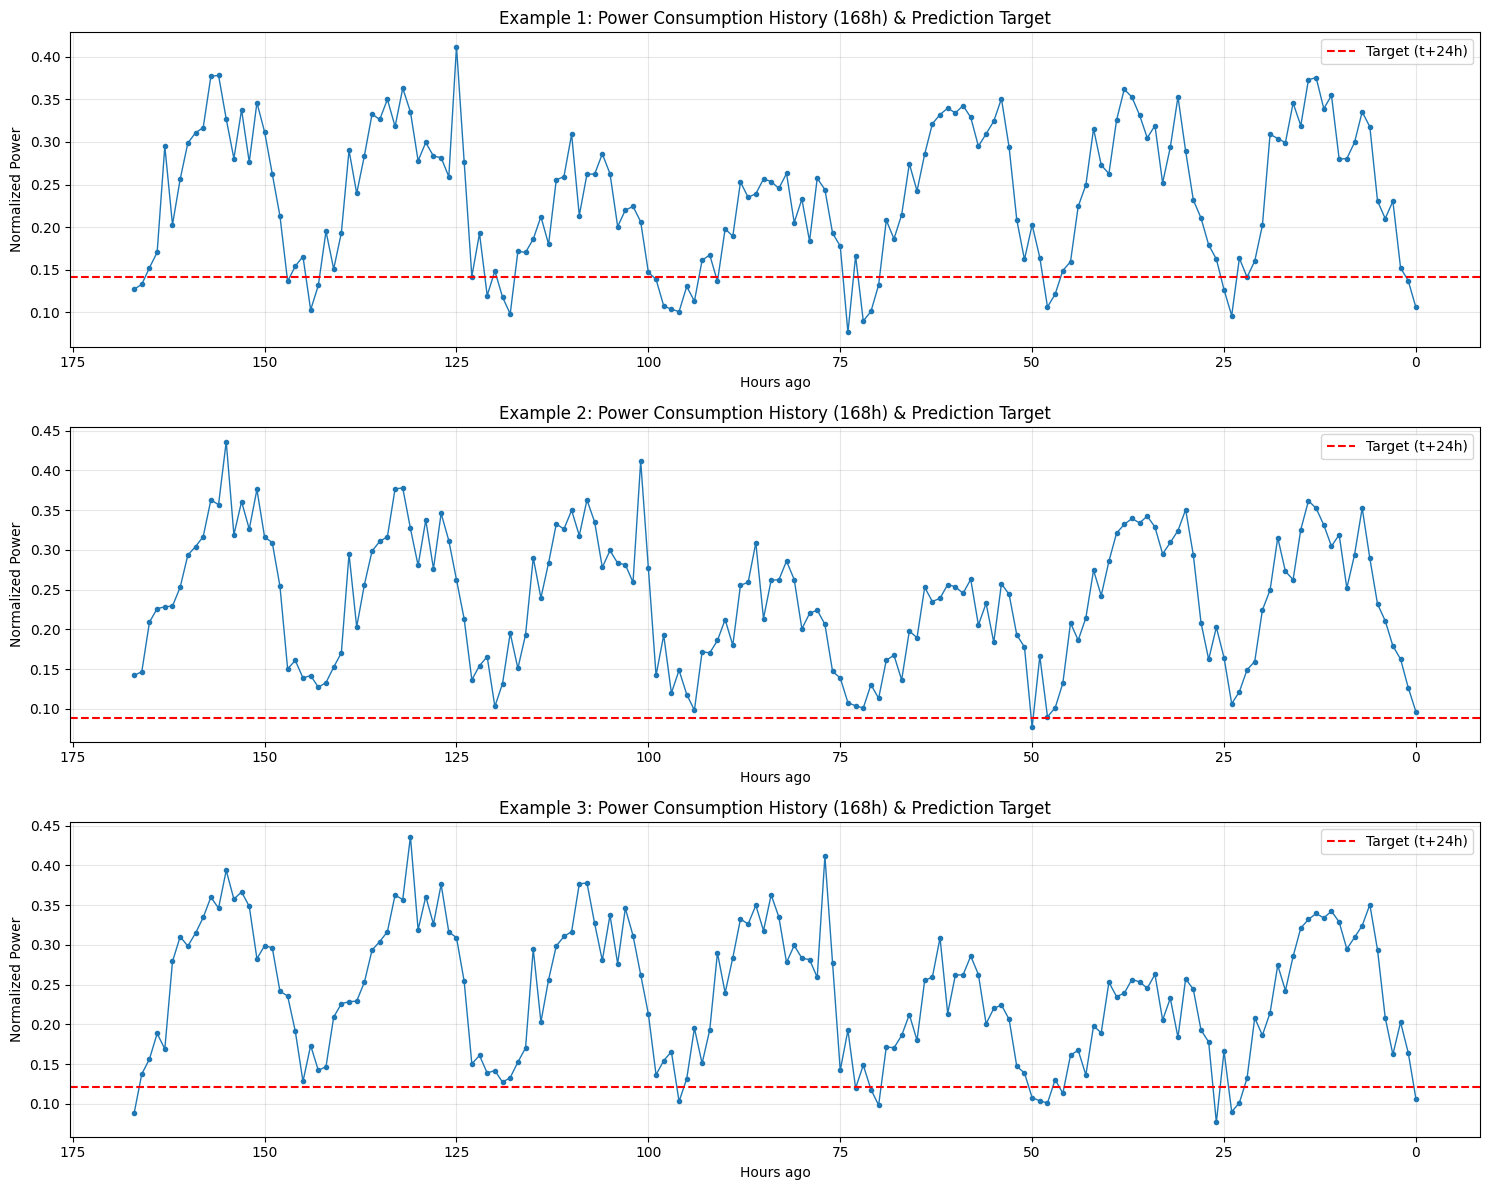

In [13]:
"""## Visualize Transformed Features"""

def visualize_transformed_features(dataset, n_examples=3):
    """Visualize transformed features from windowed dataset."""

    for batch_features, batch_targets in dataset.take(1):
        fig, axes = plt.subplots(n_examples, 1, figsize=(15, 4*n_examples))

        if n_examples == 1:
            axes = [axes]

        for i in range(min(n_examples, len(batch_features))):
            # Get power consumption history (last feature)
            power_history = batch_features[i][:, -1].numpy()

            # Plot
            axes[i].plot(range(len(power_history)), power_history,
                        marker='o', markersize=3, linewidth=1)
            axes[i].axhline(y=batch_targets[i].numpy(), color='r',
                           linestyle='--', label=f'Target (t+{FUTURE_TARGET}h)')
            axes[i].set_title(f'Example {i+1}: Power Consumption History (168h) & Prediction Target')
            axes[i].set_xlabel('Hours ago')
            axes[i].set_ylabel('Normalized Power')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            axes[i].invert_xaxis()

        plt.tight_layout()
        plt.show()
        break

visualize_transformed_features(train_dataset, n_examples=3)